# Lab 5, Radio Communication Via a Computer Interface, Part I

Now that you have gotten your radio and radio interfaces, we are ready to experiment with them. In this part of the lab we will learn how to use the interface and the radio, make sure that everything is working correctly so that you will be able to make progress on the second part as well as the project. It is important that you start early, since there may be many technical difficulties. 

<center><img src="https://inst.eecs.berkeley.edu/~ee123/sp15/usbiface.jpg" alt="gsm" style="width: 400px;"/></center>
<center>Figure 1: The Computer-Radio Audio Interface</center>

The interface you got contains a usb hub that connects to your labtop. The usb hub has two devices: A USB audio card in which you will send and receive audio to your radio, and the CP2102 USB to serial that enables you to key the radio from your python script using the pyserial library. The interface also has a ground-loop isolation box. It has two audio transformers that prevent voltage potential from your computer to get to the radio. The isolation box has a Kenwood style audio connector with a 2.5mm and 3.5mm audio Jack that connects to your Baofeng radio.  


**Prerequisites:**
* You will need to install pyserial by running the command in command line: 
        pip install pyserial
* You will need to install the usb-to-serial drivers from https://www.silabs.com/products/mcu/Pages/USBtoUARTBridgeVCPDrivers.aspx

**Starting:**

* Make sure that the channel you will use is not already in use by someone else
* Choose one of the experimental channels (101-108) in the programmed channels on your radio, preferably a UHF one (105-108)
* Before starting, you must identify with your call sign and that you intend to use this channel for performing experiments
* Connect the audio interface to the radio and to the USB hub to your computer
* Make sure in your computer settings that the volume on the USB interface is set to 3/4 of the max to prevent overloading the radio input and that both input and output are not on mute. 
* Make sure the output volume on the radio is reasonable to prevent overloading of the usb interface. Turning clockwise when the radio is off for 1/4 of a turn works well for me. 

**During operation:**

* If the green light on the radio turns on frequently, it means that someone is transmitting on your channel. In that case, switch to a different one. 
* If the red light turns on, the radio is transmitting. If it is not supposed to, then something got messed up with the USB to TTL device. It's probably went AWOL due to RF interference.  Unplug the USB hub and plug it back again. Don't forget to reset the notebook kernel
* Announce your callsign every 10 minutes
* Make sure that the antenna is not close to the audio cable and is as orthogonal as possible to it  -- this will prevent RF to get into the audio interface. 
* Sometimes, the usb audio device will stop working due to RF overloading. To prevent that, put your radio further away as possible from the interface.
* Use low-power (# key) when possible

**Finishing:**

* Sign off with your call sign

** RF interference from radio transmission that makes either the USB audio, USB to serial or your USB hub fail is \#1 cause of technical issues in this lab. If that happens **
* Make sure the antenna is not aligned with any cable
* Make sure the radio is far as possible from teh interface
* Put your radio on a shelf or elevated
* Ask us for more Ferrite beeds to put on your cables. 


Let's first define the spectrogram function, which we will use later in the lab

## Buffered Audio I/O

In order to enable convenient audio processing in real-time, we modified the I/O audio functions to use threading and python queues. The nice thing about queue is that it implements a buffered FIFO which we will use to fill in with captured samples or samples we would like to transmit. 

We are also going to use a nice feature in PyAudio that lets you access different audio interfaces. For example, you can record audio from the USB dongle and play it on the computer built-in speaker at the same time. 

The function play_audio has some other optional parameters for controlling the PTT of your radio. We will talk about that later. 


### Finding your audio device numbers

To find the device numbers of the built in input/output and the USB devices, we wrote the following function, which prints out the device number followed by the device name. We are interested in four devices:
- `daudio_out` - Laptop Speaker
- `daudio_in` - Laptop Microphone
- `dusb_out` - Radio-Laptop interface output (transmitter)
- `dusb_in` - Radio-Laptop interface input (receiver)

Run the following code cell to see a list of available devices and manually set the device numbers `dout`, `din`, `dusb_out` and `dusb_in` to the desired device numbers in the next code cell. Match the following key words in the device name:

- `daudio_out` - Windows: "Output", "Speaker", Mac: "Built-in Output"
- `daudio_in` - Windows: "Input", "Microphone",  Mac: "Built-in Microph "
- `dusb_out` - Windows: "USB", "Speaker", "Output", Mac: "USB PnP Sound Device"
- `dusb_in` - Windows: "USB", "Microph", "Input", Mac: "USB PnP Sound Device"

**You will need to reset the device numbers every time you plug-in your device**


In [3]:
# # # Serialize object
# f = open('jonsOH.pickle', 'wb')
# pickle.dump(y, f, protocol=pickle.HIGHEST_PROTOCOL)
# f.close()

In [24]:
# Import functions and libraries
%pylab 
import numpy as np
import matplotlib.pyplot as plt
import pyaudio, Queue, threading,time, sys, threading,time, serial
from __future__ import division
from numpy import pi, sin, zeros, r_
from scipy import signal
from rtlsdr import RtlSdr

import cPickle as pickle
# # # Serialize object
# f = open('pick_name.pickle', 'wb')
# pickle.dump(NN, f, protocol=pickle.HIGHEST_PROTOCOL)
# f.close()

# Load object
# f = open('linear_y_sine_.pickle', 'rb')
# Y = pickle.load(f)
# f.close()

%matplotlib inline

# function to compute average power spectrum
def avgPS( x, N=256, fs=1):
    M = floor(len(x)/N)
    x_ = reshape(x[:M*N],(M,N)) * np.hamming(N)[None,:]
    X = np.fft.fftshift(np.fft.fft(x_,axis=1),axes=1)
    return r_[-N/2.0:N/2.0]/N*fs, mean(abs(X)**2,axis=0)


# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spect

def sg_plot( t_range, f_range, y, dbf = 60, fig = None) :
    eps = 10.0**(-dbf/20.0)  # minimum signal
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( (abs( y ) / y_max)*(1-eps) + eps )
    
    # rescale image intensity to 256
    img = 256*(y_log + dbf)/dbf - 1
    
    fig=figure(figsize=(16,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()
    
    return fig


def myspectrogram_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    
    isreal_bool = isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = append(x,zeros(-lx+nt*m))
    x = x.reshape((m/2,nt*2), order='F')
    x = concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        sg_plot(t_range, f_range, xmf[0:m/2,:],dbf=dbf)
        print 1
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        sg_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

def play_audio( Q,ctrlQ ,p, fs , dev, ser="", keydelay=0):
    # play_audio plays audio with sampling rate = fs
    # Q - A queue object from which to play
    # ctrlQ - A queue object for ending the thread
    # p   - pyAudio object
    # fs  - sampling rate
    # dev - device number
    # ser - pyserial device to key the radio
    # keydelay - delay after keying the radio
    #
    #
    # There are two ways to end the thread: 
    #    1 - send "EOT" through  the control queue. This is used to terminate the thread on demand
    #    2 - send "EOT" through the data queue. This is used to terminate the thread when data is done. 
    #
    # You can also key the radio either through the data queu and the control queue
    
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),output=True,output_device_index=dev)
    # play audio
    while (1):
        if not ctrlQ.empty():
            
            # control queue 
            ctrlmd = ctrlQ.get()
            if ctrlmd is "EOT"  :
                    ostream.stop_stream()
                    ostream.close()
                    print("Closed  play thread")
                    return;
            elif (ctrlmd is "KEYOFF"  and ser!=""):
                ser.setDTR(0)
                #print("keyoff\n")
            elif (ctrlmd is "KEYON" and ser!=""):
                ser.setDTR(1)  # key PTT
                #print("keyon\n")
                time.sleep(keydelay) # wait 200ms (default) to let the power amp to ramp up
                
        
        data = Q.get()
        
        if (data is "EOT") :
            ostream.stop_stream()
            ostream.close()
            print("Closed  play thread")
            return;
        elif (data is "KEYOFF"  and ser!=""):
            ser.setDTR(0)
            #print("keyoff\n")
        elif (data is "KEYON" and ser!=""):
            ser.setDTR(1)  # key PTT
            #print("keyon\n")
            time.sleep(keydelay) # wait 200ms (default) to let the power amp to ramp up
            
        else:
            try:
                ostream.write( data.astype(np.float32).tostring() )
            except:
                print("Exception")
                break
            
def record_audio( queue,ctrlQ, p, fs ,dev,chunk=1024):
    # record_audio records audio with sampling rate = fs
    # queue - output data queue
    # p     - pyAudio object
    # fs    - sampling rate
    # dev   - device number 
    # chunk - chunks of samples at a time default 1024
    #
    # Example:
    # fs = 44100
    # Q = Queue.queue()
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # record_audio( Q, p, fs, 1) # 
    # p.terminate() # terminate pyAudio
    
   
    istream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),input=True,input_device_index=dev,frames_per_buffer=chunk)

    # record audio in chunks and append to frames
    frames = [];
    while (1):
        if not ctrlQ.empty():
            ctrlmd = ctrlQ.get()          
            if ctrlmd is "EOT"  :
                istream.stop_stream()
                istream.close()
                print("Closed  record thread")
                return;
        try:  # when the pyaudio object is distroyed stops
            data_str = istream.read(chunk) # read a chunk of data
        except:
            break
        data_flt = np.fromstring( data_str, 'float32' ) # convert string to float
        queue.put( data_flt ) # append to list



def printDevNumbers(p):
    N = p.get_device_count()
    for n in range(0,N):
        name = p.get_device_info_by_index(n).get('name')
        print n, name

p = pyaudio.PyAudio()
printDevNumbers(p)
p.terminate()

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib
0 AirPlay
1 Built-in Microph
2 Built-in Output
3 USB PnP Sound Device


`%matplotlib` prevents importing * from pylab and numpy


In [25]:
###### CHANGE #######
daudio_in = 1
daudio_out = 2
dusb_in = 3
dusb_out = 3

In [26]:
s = serial.Serial(port='/dev/tty.SLAB_USBtoUART')

### Testing the Buffered Audio:

The first test/example would be to see if we can capture audio from the radio and play it on the computer.

* Connect the audio interface to the radio and to the USB audio dongle. Insert the USB device. 
* On the radio, press on the orange button to switch to FM radio mode. Tune to 94.1 KPFA. Set the volume at quarter of a turn. You can also tune to the SPLXCAL frequency (ch4 or 146:430MHz on your radio) and ask a friend to transmit to you to see if you can hear the result through the speakers. 
* The following code records the audio that is coming out of the radio into the usb port and plays it on the computer built-in speakers. Study it! It will be very usefull in the future. 

#### An important feature in this task is that you now have a method to check if the incoming signal is being clipped. Remember the settings for which the signal maximum is 0.6.  This would be VERY useful in the communications part of the lab

In [27]:
# create an input output FIFO queues
Qin = Queue.Queue()
Qout = Queue.Queue()

# create a control fifo to kill threads when done
cQin = Queue.Queue()
cQout = Queue.Queue()

# create a pyaudio object
p = pyaudio.PyAudio()

# get sampling rate from pyaudio
fs_usb = p.get_device_info_by_index(dusb_in)['defaultSampleRate']


# initialize a recording thread. 
t_rec = threading.Thread(target = record_audio,   args = (Qin, cQin,p, fs_usb, dusb_in))

# initialize a playing thread. 
t_play = threading.Thread(target = play_audio,   args = (Qout,cQout,  p, fs_usb, daudio_out))

# start the recording and playing threads
t_rec.start()
t_play.start()

# give some time before starting
time.sleep(1)


# record and play about 10 seconds of audio 430*1024/44100 = 9.98 s
mxpwr = zeros(430)
rmspwr = zeros(430)

for n in range(0,430):
    
    samples = Qin.get()
    mxpwr[n] = max(abs(samples))
    rmspwr[n] = np.sqrt(np.sum(np.square(samples)))
    # You can add code here to do processing on samples in chunks of 1024
    # you will have to implement an overlap an add, or overlap an save to get
    # continuity between chunks
    
    Qout.put(samples)
    
    
#Close threads 
cQout.put('EOT')
cQin.put('EOT')
time.sleep(3) # give time for the thread to get killed


# clear Queues 

with Qin.mutex:
    Qin.queue.clear()
with Qout.mutex:
    Qout.queue.clear()
with cQin.mutex:
    cQin.queue.clear()
with cQout.mutex:
    cQout.queue.clear()
    
p.terminate()

Closed  record thread
Closed  play thread


In [28]:
def play( data, p, fs):
    # data - audio data array
    # p    - pyAudio object
    # fs    - sampling rate
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=fs,output=True)
    # play audio
    ostream.write( data.astype(np.float32).tostring() )

* The code also displays the RMS power and Maximum audio signal for each 1024 samples-- so you can see if it is clipped, or too weak.

('Avg maxpwr', 0.0053718034611191859)
Audio Volume may be too low. Increase it, for better lab performance


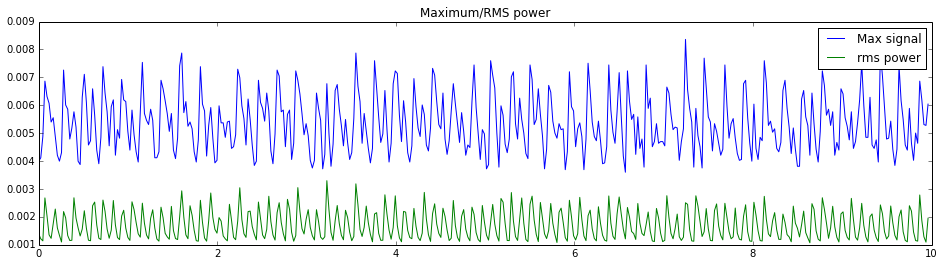

In [29]:
fig = figure(figsize=(16,4))
t = r_[0:430]*1024.0/44100
plt.plot(t,mxpwr)
plt.plot(t,rmspwr/sqrt(1024))
plt.title('Maximum/RMS power')
plt.legend(('Max signal','rms power'))

print('Avg maxpwr',np.mean(mxpwr))
if any(mxpwr > 0.95):
    print("Warning! Signal is clipped. Reduce radio volume, and/or usb device input volume")
if max(mxpwr) < 0.3:
    print("Audio Volume may be too low. Increase it, for better lab performance")

### Testing  Radio Transmit control

The next step is to test if the PTT control using pyserial works 

* Follow the preparation steps listed in the beginning of the document (identify your callsign and announce testing)
* Pick an experimental channel 101-107
* Set the power of the radio to low if it's not set already (short press the # key. shows up as a small 'L')


The following code generates a series of 10 short key-on, key off. To key the radio, you need to set the DTR pin of the USB to serial device to '1' and to stop keying set it back to '0'  

If the red light turns on and off, you are good to go!

#### \*\*\*Mac users: Check the com part of your usb-to-serial device with the following command in the command line and use the right one in the code
    ls /dev/tty.*
#### \*\*\*Windows users: Check the com port of your usb-to-serial device following http://hy-bon.com/files/4814/4250/7490/com_port_vista.pdf and use the right one in the code

## WARNING: This is where things may fail to to RF interference. If your radio does not stop transmitting, unplug the USB from your computer! Look above for tips for solving interference problems. **

In [31]:
# s = serial.Serial(port='/dev/tty.SLAB_USBtoUART')
s.setDTR(0)

for n in range(0,10):
    s.setDTR(1)
    time.sleep(0.25)
    s.setDTR(0)
    time.sleep(0.25)

# Controlling the PTT through the play_audio function

To make it easier on you, we integrated the option of keying and unkeying the radio through the play_audio function.

- When the function `play_audio()` pulls from the DATA queue the command `KEYON`, it will set DTR to 1 (which will key the radio) and then wait for 200ms (default can be modified) for the radio to turn on. 
- When it pulls `KEYOFF` from the DATA queue, it will set DTR to 0 (which will key off the radio).
- When it pulls `EOT` from the control queue, it will quit.

Below is a code that: 
- keys the radio
- plays a 2KHz tone for 2 second
- unkeys the radio
- plays for 2 seconds without transmitting
- keys the radio and plays a 1kHz tone for 2 seconds 
- unkeys the radio.

Use a friend's radio or the SDR (with Gqrx) to make sure you hear the audio. 


In [32]:
# creates a queue
Qout = Queue.Queue()
cQout = Queue.Queue()

# initialize a serial port (use COM1-9 for windows) 
# s = serial.Serial(port='/dev/tty.SLAB_USBtoUART')
s.setDTR(0)

# create a pyaudio object
p = pyaudio.PyAudio()

# get sampling rate
fs_usb = p.get_device_info_by_index(dusb_out)['defaultSampleRate']

# generate sinusoids
t = r_[0:2*fs_usb]/fs_usb
sig2 = 0.5*sin(2*pi*2000*t)
sig1 = 0.5*sin(2*pi*1000*t)

Qout.put("KEYON")
Qout.put(sig2)
Qout.put("KEYOFF")
Qout.put(sig2)
Qout.put("KEYON")
Qout.put(sig1)
Qout.put("KEYOFF")
Qout.put("EOT")


# play audio from Queue 

play_audio(Qout, cQout, p, fs_usb, dusb_out, s,0.2)

time.sleep(2)
p.terminate()

Closed  play thread


### Below is a similar code, but running with threads in the background.

Study it, it would be useful later in the communication part. 

In [33]:
# creates a queue
Qout = Queue.Queue()
cQout = Queue.Queue()

# initialize a serial port (use COM1-9 for windows) 
# s = serial.Serial(port='/dev/tty.SLAB_USBtoUART')
s.setDTR(0)

# create a pyaudio object
p = pyaudio.PyAudio()

# get sampling rate
fs_usb = p.get_device_info_by_index(dusb_out)['defaultSampleRate']

t = r_[0:2*fs_usb]/fs_usb
sig2 = 0.25*sin(2*pi*2000*t)
sig1 = 0.25*sin(2*pi*1000*t)

t_play = threading.Thread(target = play_audio, args = (Qout, cQout,  p, fs_usb, dusb_out, s ,0.2 ))


# play audio from Queue 
t_play.start()

Qout.put("KEYON")
Qout.put(sig2)
Qout.put("KEYOFF")
Qout.put(sig2)
Qout.put("KEYON")
Qout.put(sig1)
Qout.put("KEYOFF")
Qout.put("EOT")

# must wait for the queue to empty before terminating pyaudio
while not(Qout.empty()) :
    time.sleep(1)


time.sleep(1)
p.terminate()


Closed  play thread


### Calibrating the Input Audio level to the radio using Radio transmission and reception with the SDR. 

The audio input to the radio is filtered in the radio by a bandpass filter, which passes frequencies roughly between 500Hz and 4KHz. The input filter also emphasizes the high frequencies with approximately 6db per decade. 

In later parts of the lab, we will send audio to the radio which encodes digital data. It is important that we have a way to set the right level of outputs such that there's no overdriving and clipping of the signal. 

In this task, we will transmit a pure audio tone with increasing amplitude, receive and demodulate with the SDR and determine the amplitude in which the signal is still "Well behaved" and not clipped or have non-linearities. 

How will it work: 
* We will generate a tone with increasing amplitudes in python
* The USB audio interface will convert it to an analog signal
* The radio will filter the input with a bandpass filter
* The radio will FM modulate the signal with $\pm7.5$KHz deviation at the chosen center frequency and transmit the FM signal.
* The SDR will capture samples around that center frequency
* You will implement a carrier squelche that would choos only the samples corresponding to the transmission.
* you will FM demodulate the signal by implementing a low-pass filter, limiter, discriminator similarly to lab 3. 
* You will then look at the amplitude of the received tone and figure at what time it maxed out. This will correspond the the maximum value for an audio signal with your audio settings that will not be distorted!

#### Setup
* Connect the SDR to the USB port in the interface. 
* Disconnect the antenna from the SDR -- the signal will be stong anyways and we don't want to saturate the SDR. 
* Place the radio as far away from the SDR as possible to minimize interference
* Set your radio to one of the experimental channel on the radio (channels 101-108) with low-power. It's recommended to use the UHF channels 105-108 first-- but if they are occupied use the VHF.


#### Pre-Task:  Setting the gain of the SDR and calibrating the frequency

Before we start, we would like to make sure that the SDR frequency is calibrated to the radio (both may have some offset). We would also like to adjust the gain of the SDR, so it is not under/overdriven by the radio. 

For this, we only need to key the radio and receive using the SDR. This will transmit a carrier at the center frequency. We will look at the spectrum to calibrate the offset of the SDR with respect to the radio. We will look at the magnitude signal to see if its clipped. 

* Acquire 4 seconds of data while the radio is being keyed
* Plot the amplitude of the signal.  Make sure the amplitude of the signal is > 0.25, and < 0.75, if not, change the gain or move the SDR away from the radio
* Plot the average power specrum, or the spectrogram, and calculate the offset frequency. Find its approximate ppm drift. 
* Repeat the above till the magnitude of the signal is within range and its frequency is centered. 
* Record the sdr gain and the ppm shift. You will need to use it later.




In [57]:
# initialize a serial port (use COM1-9 for windows) 
# s = serial.Serial(port='/dev/tty.SLAB_USBtoUART')
s.setDTR(0)

# Setup SDR
fs_sdr = fs = 240000
fc =    144.970e6 # set your frequency!
ppm =   26 # set estimate ppm
gain =  26 # set gain

sdr = RtlSdr()
sdr.sample_rate = fs_sdr    # sampling rate
sdr.gain = gain
sdr.center_freq = fc
sdr.set_freq_correction(ppm)

# start transmitting
s.setDTR(1)
y = sdr.read_samples(256000*6)
# stop transmitting
s.setDTR(0)
sdr.close()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


('Offset:', 0.0)
shift in Hz: 0.0
shift in ppm: 0.0


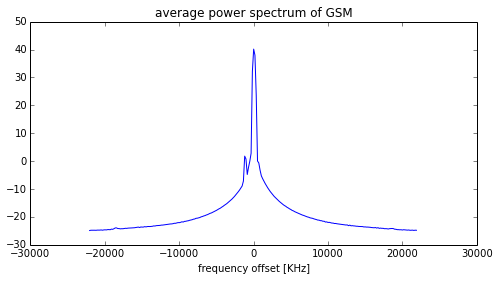

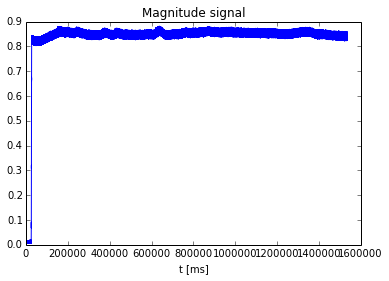

In [58]:
# Code to plot magnitude signal and compute frequency offset
# Here:
f, sp = avgPS(y,N=256,fs=fs_usb)
fig = figure(figsize=(8,4))
plot(f,10*log10(sp))
title('average power spectrum of signal')
xlabel('frequency offset [KHz]')
offset = f[np.argmax(10*log(sp))]
print('Offset:', offset)

# plot 
fig = figure(figsize=(16,4))
figure()
plot(abs(y))
title('Magnitude signal')
xlabel('t [ms]')

f0 = offset = f[np.argmax(10*log(sp))]
ppmcalib = offset * 1e6  / fc

print 'shift in Hz:', f0
print 'shift in ppm:',ppmcalib

Now that the SDR frequency and gain are calibrated, let's start with the calibration of the audio level to the radio.

#### Task
* Make sure the output volume settings on the USB device is 1/2 of the way. (Windows or mac audio settings) 
* Generate a 4 seconds tone at 2200Hz. The tone amplitude should vary linearly from 0 to 1 throughut the 4 seconds. 
* Transmit the signal using the radio and simultaniously receive using the SDR for 4 seconds. 
* Plot the Spectrogram of the received signal. Do you see that the bandwidth is increasing?



In [311]:
# generate the tone
# your code here:

# Initial pyaudio and Queues
p = pyaudio.PyAudio()
Q = Queue.Queue()
cQ = Queue.Queue()

# initialize a serial port (use COM1-9 for windows) 
s = serial.Serial(port='/dev/tty.SLAB_USBtoUART')
s.setDTR(0)

# get sampling rate
fs_usb = p.get_device_info_by_index(dusb_out)['defaultSampleRate']

# generate sinusoids
t = r_[0:4*fs_usb]/fs_usb
tone_freq = 2200*2*pi
sig = (t/max(t))*sin(tone_freq*t)*(0.1)

# Setup SDR
fs_sdr = 240000
fc = fc    # center     # set your frequency!
ppm =   22 # set estimate ppm
gain =  20 # set gain


sdr = RtlSdr()
sdr.sample_rate = fs_sdr    # sampling rate
sdr.gain = gain
sdr.center_freq = fc
sdr.set_freq_correction(ppm)


# Fill the queue
Q.put(zeros(fs_usb/2))  # wait 1/2 second
Q.put('KEYON')          # start transmitting
Q.put(zeros(fs_usb/2))  # wait 1/2 second 
Q.put(sig)              # start playing audio
Q.put('KEYOFF')         # stop transmitting
Q.put('EOT')         # exit thread

# initialize thread
t_play = threading.Thread(target = play_audio, args = (Q,cQ, p, fs_usb, dusb_out,s  ))

# start transmitting
t_play.start()

# read samples from SDR
y = sdr.read_samples(256000*6)

# stop transmitting when done
s.setDTR(0)
sdr.close()

# empty queue
while not(Q.empty()):
    time.sleep(1)

# terminate
time.sleep(2)
p.terminate()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:36: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:38: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Closed  play thread


#### Task

* Plot the magnitude of the receive signal, and pick a threshod to crop the samples corresponding to the transmission. 
* Again, make sure the amplitude of the signal is  > 0.25, and  < 0.75, if not, change the gain or move the SDR away from the radio
* Crop the signal to the transmission part -- make sure you have  > 4 seconds of data

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


shift in Hz: 0.0
shift in ppm: 0.0


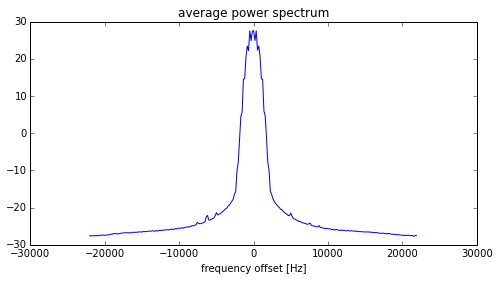

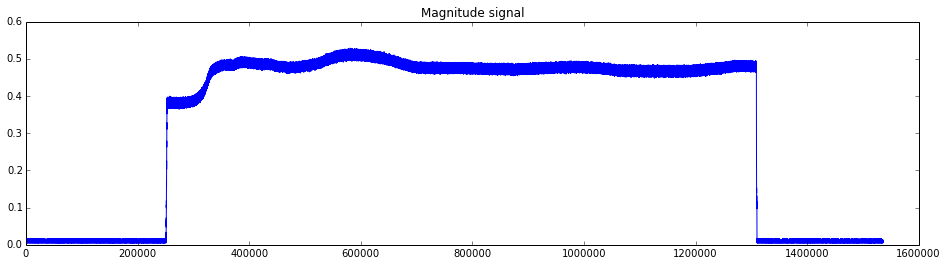

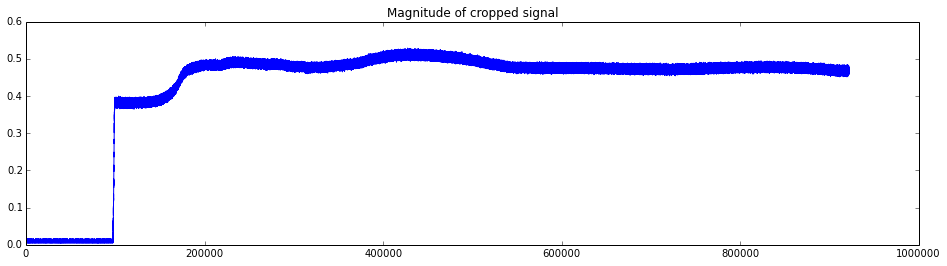

In [312]:
#your code here:
fc = fc
fs_usb = 44100
f, sp = avgPS(y,N=256,fs=fs_usb)
fig = figure(figsize=(8,4))
plot(f,10*log10(sp))
title('average power spectrum')
xlabel('frequency offset [Hz]')

# plot 
fig = figure(figsize=(16,4))
plot(abs(y))
title('Magnitude signal')

f0 = offset = f[np.argmax(10*log(sp))]
ppmcalib = offset * 1e6  / fc

y_cropped = y[len(y)//10 : len(y)*7//10]
fig = figure(figsize=(16,4))
plot(abs(y_cropped))
title('Magnitude of cropped signal')

print 'shift in Hz:', f0
print 'shift in ppm:',ppmcalib

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:74: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


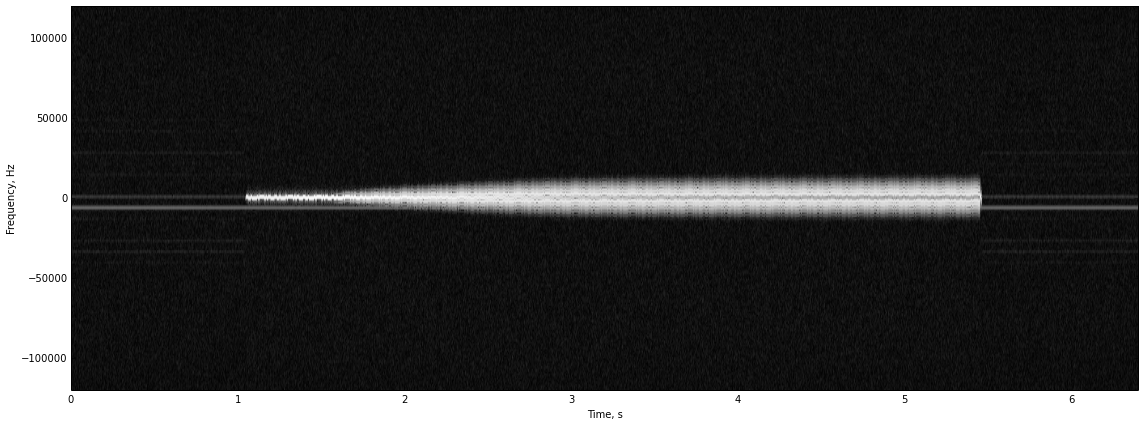

In [313]:
# Your code here
m = 256 # window length
myspectrogram_hann_ovlp(y,m,fs_sdr,0);

#### Task
* Plot the spectrogram. Make sure the signal is close to the center frequency, if not, adjust the frequency correction ppm accordingly. 
* Can you the bandwidth increasing and then leveling? Why is that happening?


In [314]:
# # # Serialize object
# f = open('linear_y_sine_.pickle', 'wb')
# pickle.dump(y, f, protocol=pickle.HIGHEST_PROTOCOL)
# f.close()

# Load object
# f = open('linear_y_sine_.pickle', 'rb')
# yyyy = pickle.load(f)
# f.close()

#### Task
* Low-pass filter with a bandwidth of 15KHz
* Downsample by 10 to 24KHz effective sampling rate
* FM - demosulate using the approach in Lab 3
* plot the spectrogram of the demosulated signal.


In [315]:
hdiff = lambda s: signal.fftconvolve(s,
                                    signal.remez(31, [0.0,10000.0,12000.0,12000.0],[1.05/1.2,0], Hz = 24e3, type='differentiator'),
                                    mode='same')

demod = lambda s: np.imag(np.conj(s)*hdiff(s))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:74: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:89: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


1


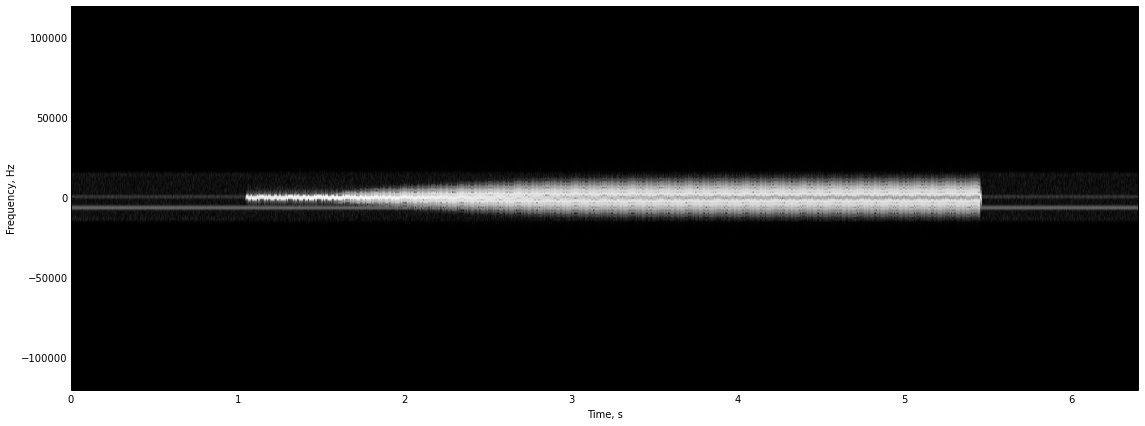

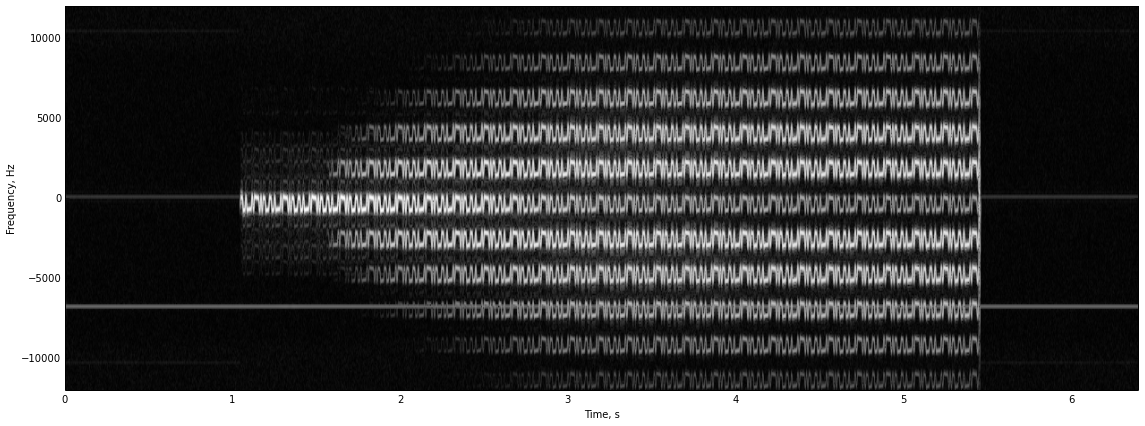

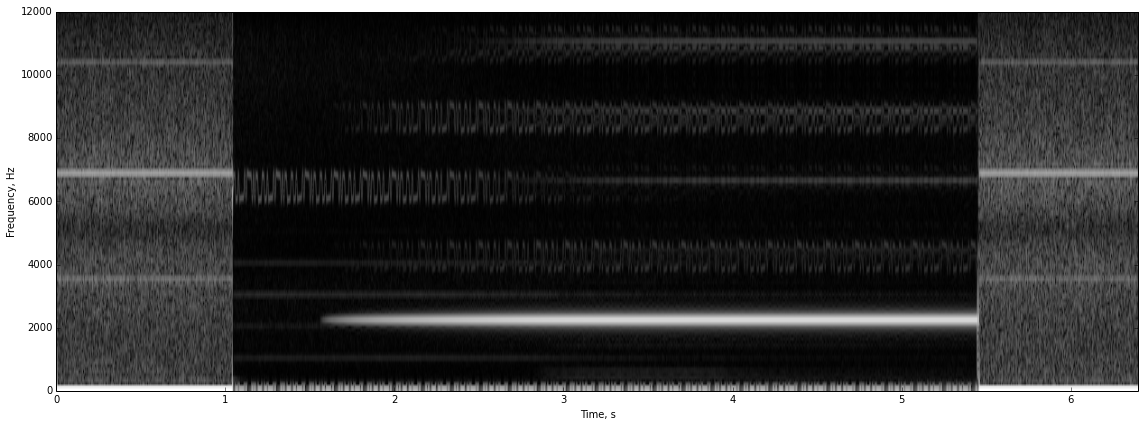

In [316]:
# your code here
m = 256
dd = 10
h = signal.firwin(513, cutoff=15e3/120e3)
filtered_data = signal.fftconvolve(y, h, 'same')

myspectrogram_hann_ovlp(filtered_data,m,fs_sdr,0);

ds = filtered_data[::dd]
myspectrogram_hann_ovlp(ds,m,fs_sdr/dd,0);

# demoded = demod(filtered_data)[::5]

demoded = demod(ds/np.abs(ds))
myspectrogram_hann_ovlp(demoded,m,fs_sdr/dd,0);

In [303]:
# p2 = pyaudio.PyAudio()
# play(demoded_norm, p2, 48000)
# p2.terminate()

#### Task
* Create narrow single side band bandpass filter by complex modulating a hanning window of length 513 to a center frequency around 2200Hz
* Filter the demodulated signal and display its magnitude (use mode='same' to compensate for the filter delay)
* You should see a linear ramp that when reaching maximum starts tapering and then becomes flat. Find the time in seconds it took from the beginning of the ramp till just before its statts to roll off. Divide that value by 4 and you've got yourself the maximum amplitude that results in a linear response!
#### Save the value of the maximum amplitude that is linear!

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:74: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


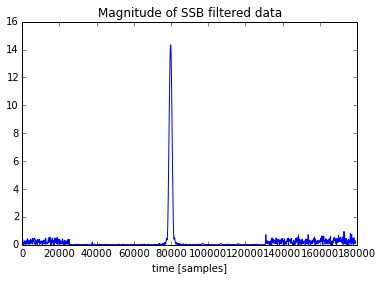

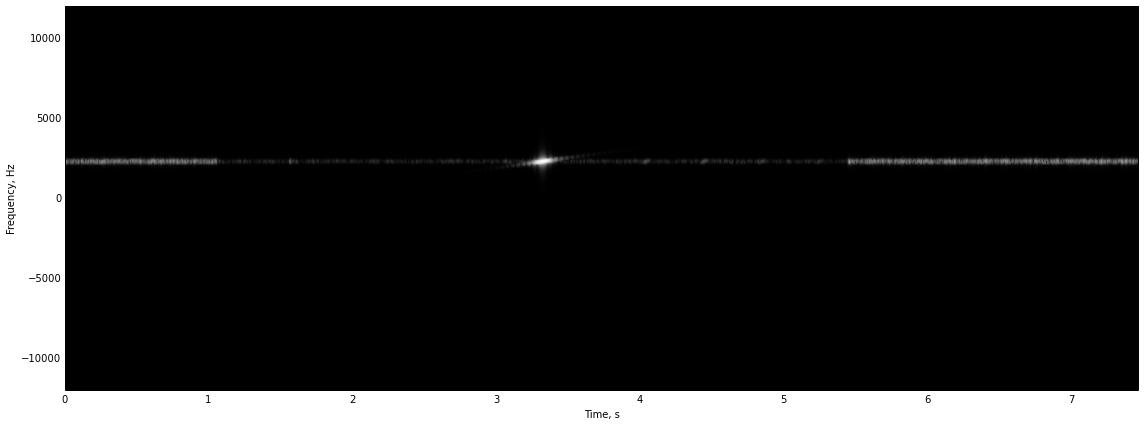

In [385]:
# your code here
freq = 2200
t = np.linspace(0,513/(fs_sdr/10),513)
modulator = np.exp(2j*pi*freq*t)
ssb_filter = np.hanning(513)*modulator

y_ssb_filt = signal.fftconvolve(demoded, ssb_filter, 'same')

plot(np.abs(y_ssb_filt))
plt.title('Magnitude of SSB filtered data')
plt.xlabel('time [samples]')

myspectrogram_hann_ovlp(y_ssb_filt,m,fs_sdr/10,0);

In [320]:
mxamp = np.abs(y_ssb_filt)[np.argmax(np.abs(y_ssb_filt))]/4
print(mxamp)

5.72381130088


##### Measuring the Frequency Response of the Radio's Bandpass Audio Filter

As mentioned earlier, the audio input to the radio is filtered by a bandpass filter. It also emphasizes the high frequencies with a filter of approximately 6db per decade. Because later we are going to use the audio interface to transmit data, we need to know how this data is going to be affected by the filter. Much like in Lab1, we will use a chirp signal to estimate the magnitude frequency response. We will trasmit with the radio and receive using the SDR.

#### Task
* Generate a chirp from 20Hz to 5KHz over 4 seconds
* Use the amplitude you got from the previous part to scale your signal
* Transmit using the radio, and record using the SDR
* Crop based on amplidute, Filter, Decimate and FM demodulate. 
* Plot the spectrogram and the magnitude frequency response of the result


In [397]:
def genChirpPulse(Npulse, f0, f1, fs):
    #     Function generates an analytic function of a chirp pulse
    #     Inputs:
    #             Npulse - pulse length in samples
    #             f0     - starting frequency of chirp
    #             f1     - end frequency of chirp
    #             fs     - sampling frequency
    
    t1 = r_[0.0:Npulse]/fs
    Tpulse = float32(Npulse) / fs 
    f_of_t = f0 + (t1) / Tpulse * (f1 - f0)
    phi_of_t = 2*pi*np.cumsum(f_of_t)/fs
    pulse = exp(1j* phi_of_t )
    return f_of_t, pulse

In [398]:
# Generating chirp.

f0 = 20 # should be e3
f1 = 5e3 # should be e3
f_, chirp = genChirpPulse(4*fs_usb, f0, f1, fs=fs_usb)
chirp = chirp/40

# Playing chirp.

# p2 = pyaudio.PyAudio()
# print('chirp len', len(chirp)/48000, 'seconds')
# play(chirp, p2, 48000)
# p2.terminate()

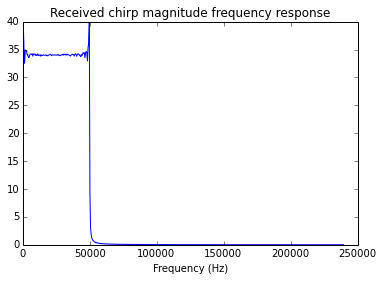

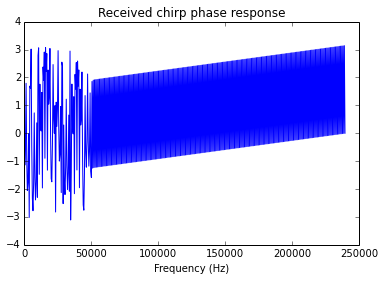

In [399]:
_, fft_chirp = signal.freqz(chirp)
phase = np.angle(fft_chirp)
# f = np.linspace(min(f0,f1), max(f0,f1), len(fft_chirp))
plt.plot(_*(fs_sdr/np.pi), abs((fft_chirp)))
plt.title("Received chirp magnitude frequency response")
plt.xlabel("Frequency (Hz)")

figure()
plt.plot(_*(fs_sdr/np.pi), phase)
plt.title("Received chirp phase response")
plt.xlabel("Frequency (Hz)")

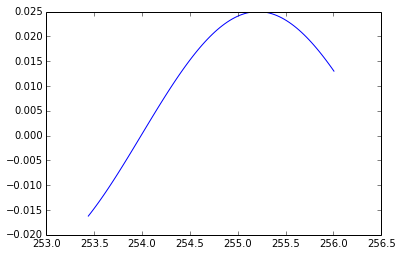

In [400]:
plot(f_[9000:9100], chirp[9000:9100])

In [401]:
### START: transmit and record ###

# Initial pyaudio and Queues
p = pyaudio.PyAudio()
Q = Queue.Queue()
cQ = Queue.Queue()

# initialize a serial port (use COM1-9 for windows) 
s = serial.Serial(port='/dev/tty.SLAB_USBtoUART')
s.setDTR(0)

# get sampling rate
fs_usb = p.get_device_info_by_index(dusb_out)['defaultSampleRate']

# Setup SDR
fs_sdr = 240000
fc = fc        # center     # set your frequency!
gain = 10
ppm = 27

sdr = RtlSdr()
sdr.sample_rate = fs_sdr    # sampling rate
sdr.gain = gain
sdr.center_freq = fc
sdr.set_freq_correction(ppm)

# Fill the queue
Q.put(zeros(fs_usb/2))  # wait 1/2 second
Q.put('KEYON')          # start transmitting
Q.put(zeros(fs_usb/2))  # wait 1/2 second 
Q.put(chirp)                                                                         # start playing: chirp
Q.put('KEYOFF')         # stop transmitting
Q.put('EOT')         # exit thread
 
# initialize thread
t_play = threading.Thread(target = play_audio, args = (Q,cQ, p, fs_usb, dusb_out,s  ))

# start transmitting
t_play.start()

# read samples from SDR
y = sdr.read_samples(256000*7)

# stop transmitting when done
s.setDTR(0)
sdr.close()

# empty queue
while not(Q.empty()) :
    time.sleep(1)

# terminate
time.sleep(2)
p.terminate()

### END: transmit and record ###

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:28: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:155: ComplexWarning: Casting complex values to real discards the imaginary part


Closed  play thread


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:74: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


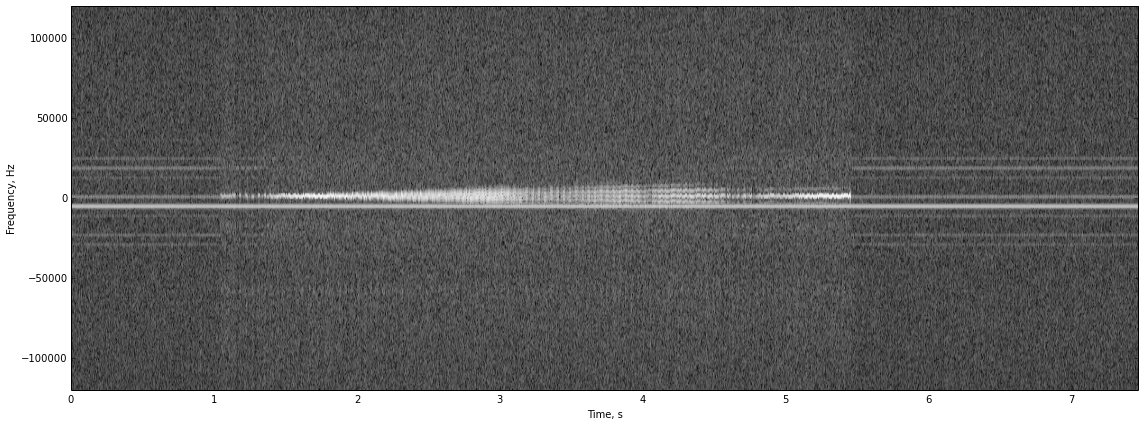

In [402]:
m = 256 # window length
myspectrogram_hann_ovlp(y,m,fs_sdr,0);

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:74: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:89: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


1


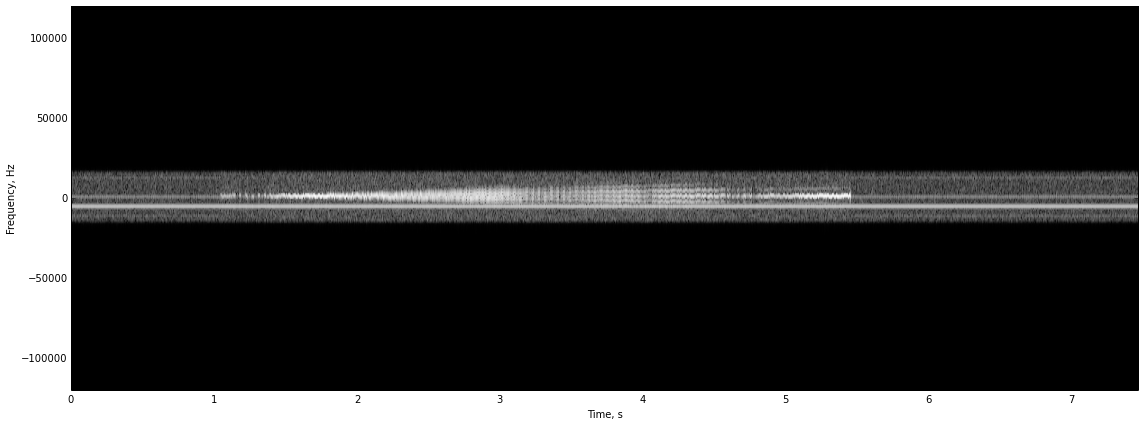

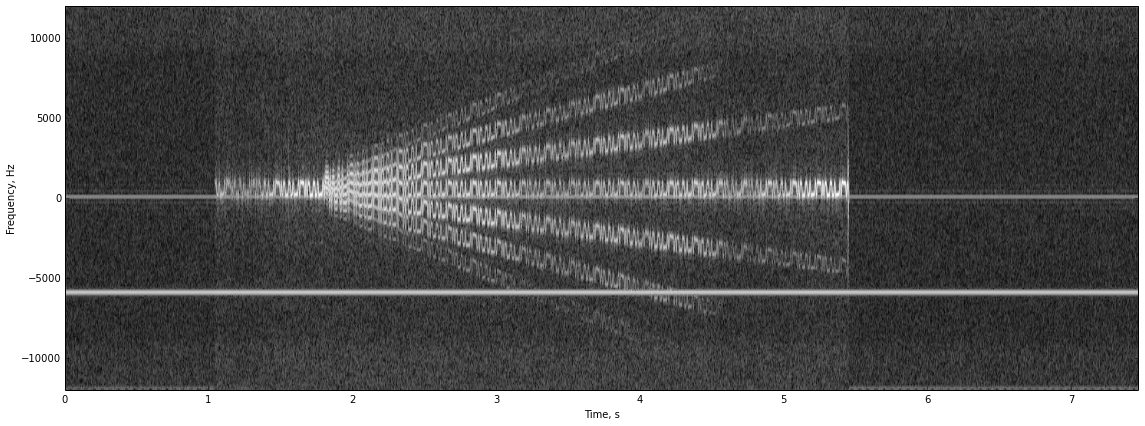

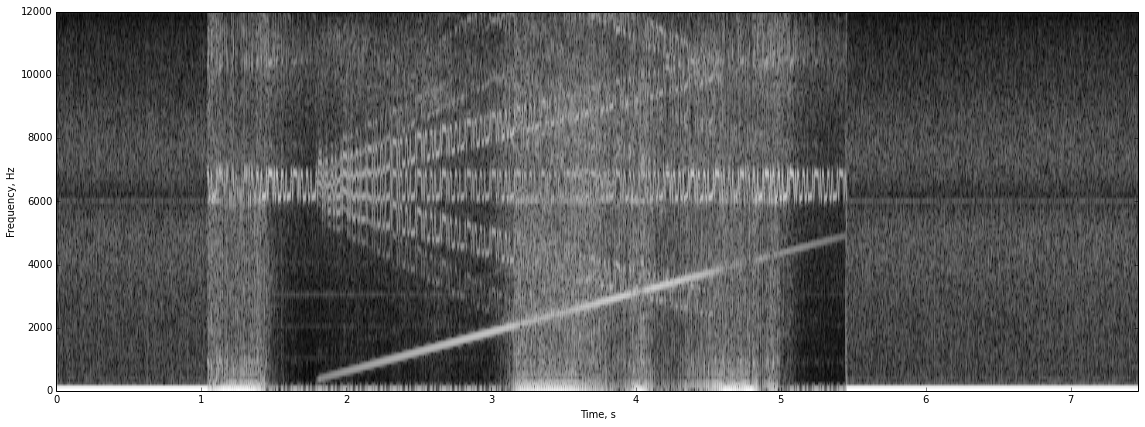

In [403]:
dd = 10
h = signal.firwin(513, cutoff=15e3/120e3)
filtered_data = signal.fftconvolve(y, h, 'same')

myspectrogram_hann_ovlp(filtered_data,m,fs_sdr,0);

ds = filtered_data[::dd]
myspectrogram_hann_ovlp(ds,m,fs_sdr/dd,0);

# demoded = demod(filtered_data)[::5]

demoded = demod(ds/np.abs(ds))
myspectrogram_hann_ovlp(demoded,m,fs_sdr/dd,0);

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:74: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


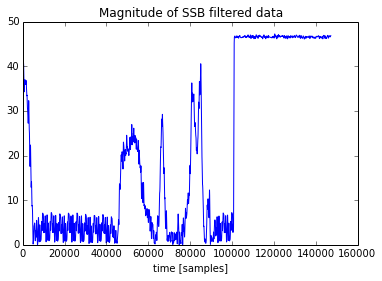

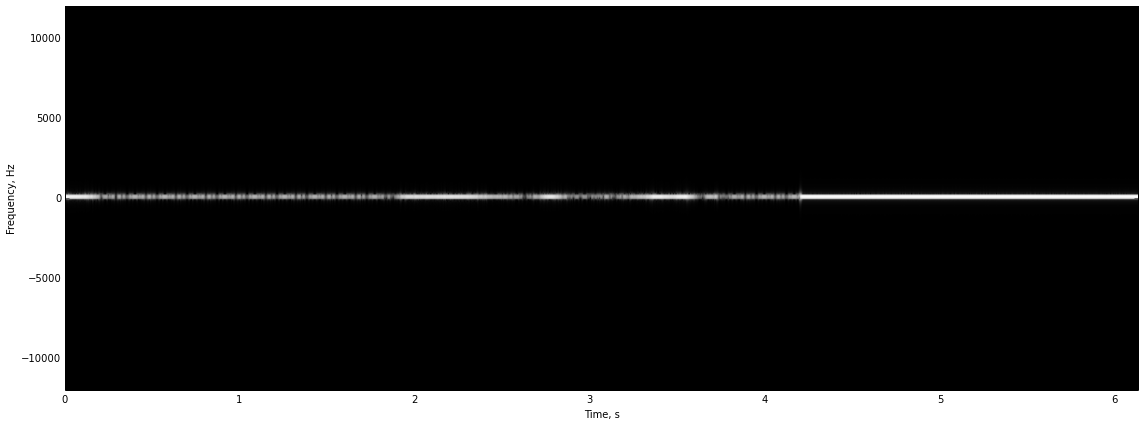

In [404]:
# your code here
freq = 20 # changed from 2.2e3 ! because of chirp freq
t = np.linspace(0,513/(fs_sdr/10),513)
modulator = np.exp(2j*pi*freq*t)
ssb_filter = np.hanning(513)*modulator

y_ssb_filt = signal.fftconvolve(demoded, ssb_filter, 'same')[30e3:-2000]

plot(np.abs(y_ssb_filt))
plt.title('Magnitude of SSB filtered data')
plt.xlabel('time [samples]')

myspectrogram_hann_ovlp(y_ssb_filt,m,fs_sdr/10,0);

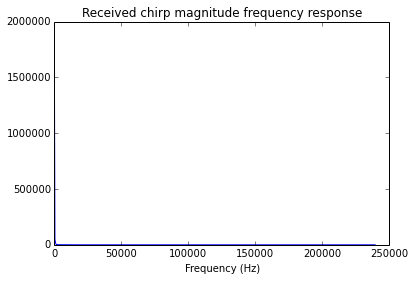

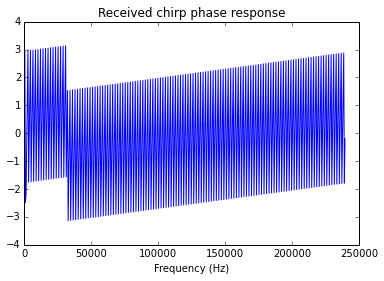

In [384]:
_, fft_chirp = signal.freqz(y_ssb_filt)
phase = np.angle(fft_chirp)

plt.plot(_*(fs_sdr/np.pi), abs((fft_chirp)))
plt.title("Received chirp magnitude frequency response")
plt.xlabel("Frequency (Hz)")

figure()
plt.plot(_*(fs_sdr/np.pi), phase)
plt.title("Received chirp phase response")
plt.xlabel("Frequency (Hz)")

In [ ]:
#Your code here:

Another way of estimating a frequency response is to trasmit white noise. White noise, much like its name has uniform energy throughout the spectrum. 

#### Task:
* Generate 4 seconds @44.1KHz of white gaussian noise using `np.random.randn`
* Scale the maximum amplitude to the value you found previously.
* Transmit using the radio, and record using the SDR
* Crop based on amplidute, Filter, Decimate and FM demodulate.
* Plot the spectrogram 

In order to display a non-noisy spectrum, we will need to compute an average power spectrum. Use the function `avgPS` to do so.

* Use a window side of 128 and Plot the square-root of the result of the positive frequencies. 

In [405]:
# generate the tone with appropriate gain
# your code here:

scale = 1
noise_sig = np.random.randn(44.1e3*4)/scale

### START: transmit and record ###

# Initial pyaudio and Queues
p = pyaudio.PyAudio()
Q = Queue.Queue()
cQ = Queue.Queue()

# initialize a serial port (use COM1-9 for windows) 
s = serial.Serial(port='/dev/tty.SLAB_USBtoUART')
s.setDTR(0)

# get sampling rate
fs_usb = p.get_device_info_by_index(dusb_out)['defaultSampleRate']

# Setup SDR
fs_sdr = 240000
fc = fc        # center     # set your frequency!
gain = 10
ppm = 27

sdr = RtlSdr()
sdr.sample_rate = fs_sdr    # sampling rate
sdr.gain = gain
sdr.center_freq = fc
sdr.set_freq_correction(ppm)

# Fill the queue
Q.put(zeros(fs_usb/2))  # wait 1/2 second
Q.put('KEYON')          # start transmitting
Q.put(zeros(fs_usb/2))  # wait 1/2 second 
Q.put(noise_sig)        # start playing: noise
Q.put('KEYOFF')         # stop transmitting
Q.put('EOT')         # exit thread
 
# initialize thread
t_play = threading.Thread(target = play_audio, args = (Q,cQ, p, fs_usb, dusb_out,s  ))

# start transmitting
t_play.start()

# read samples from SDR
y = sdr.read_samples(256000*7)

# stop transmitting when done
s.setDTR(0)
sdr.close()

# empty queue
while not(Q.empty()) :
    time.sleep(1)

# terminate
time.sleep(2)
p.terminate()

### END: transmit and record ###

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:36: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Closed  play thread


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:74: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


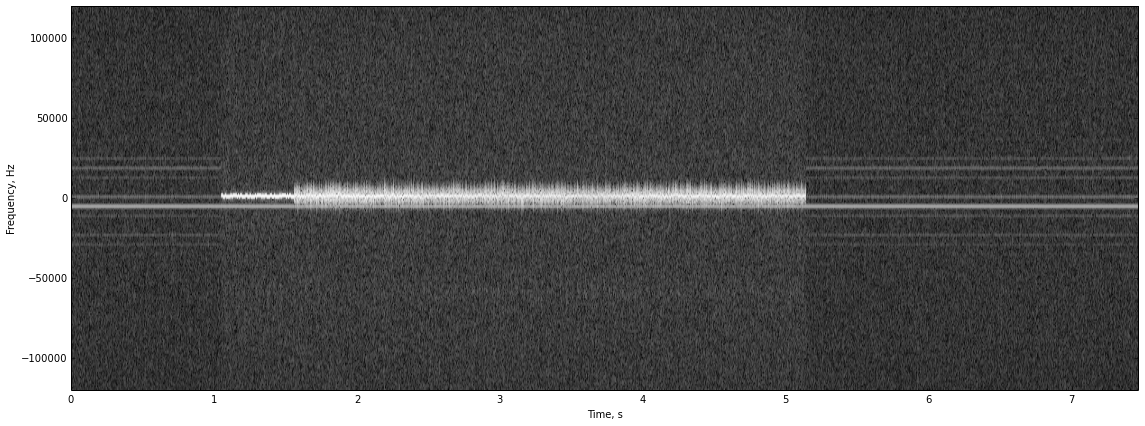

In [406]:
# Your demodulation code

m = 256 # window length
myspectrogram_hann_ovlp(y,m,fs_sdr,0);

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:74: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:89: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


1


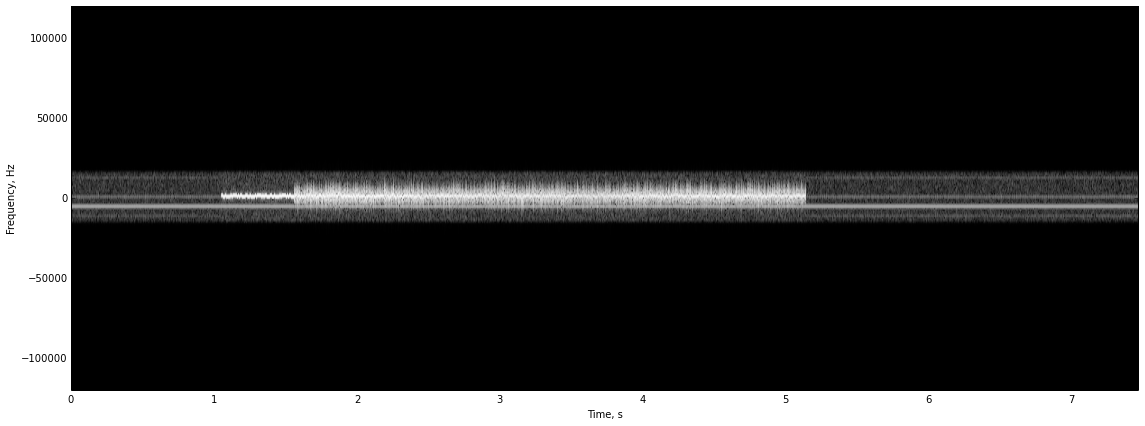

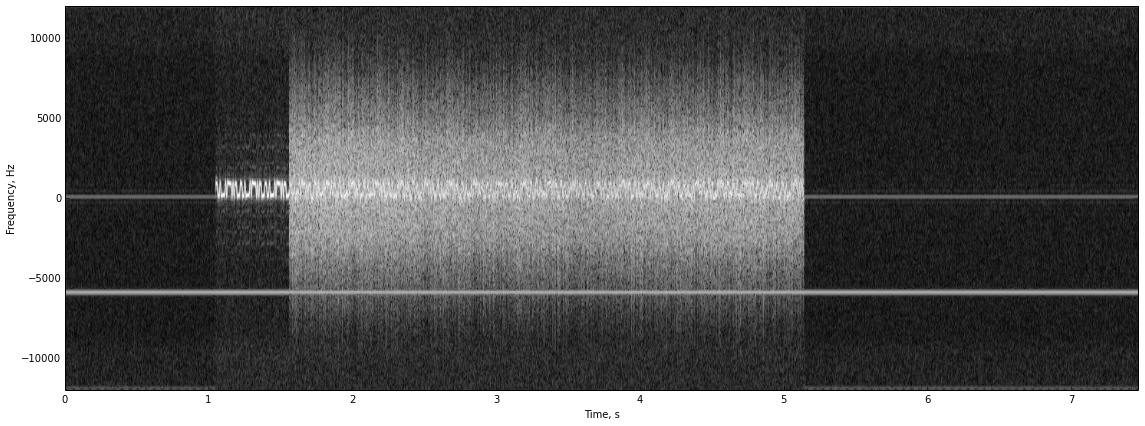

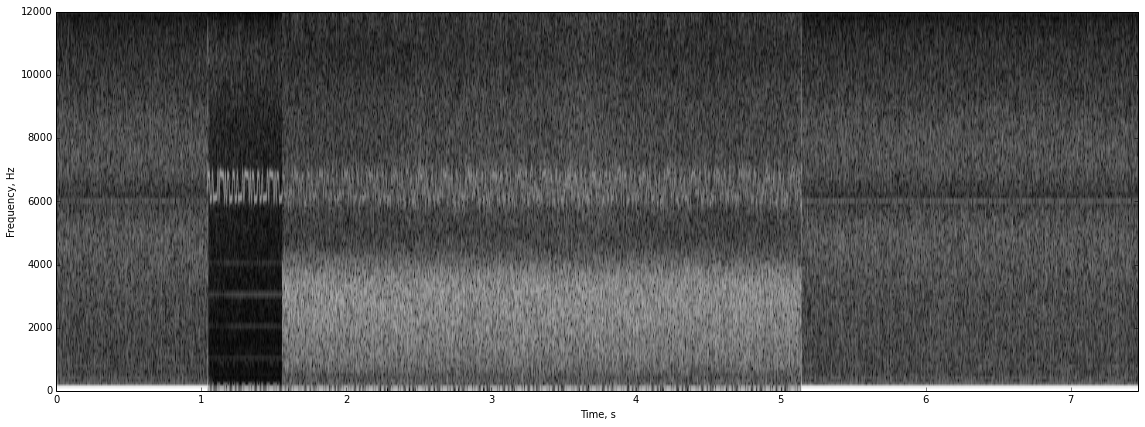

In [407]:
dd = 10
h = signal.firwin(513, cutoff=15e3/120e3)
filtered_data = signal.fftconvolve(y, h, 'same')

myspectrogram_hann_ovlp(filtered_data,m,fs_sdr,0);

ds = filtered_data[::dd]
myspectrogram_hann_ovlp(ds,m,fs_sdr/dd,0);

# demoded = demod(filtered_data)[::5]

demoded = demod(ds/np.abs(ds))
myspectrogram_hann_ovlp(demoded,m,fs_sdr/dd,0);

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:74: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


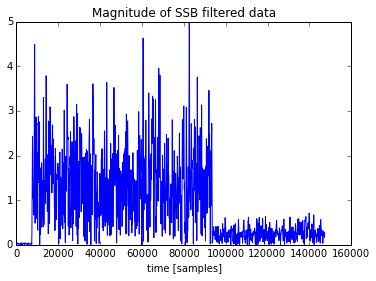

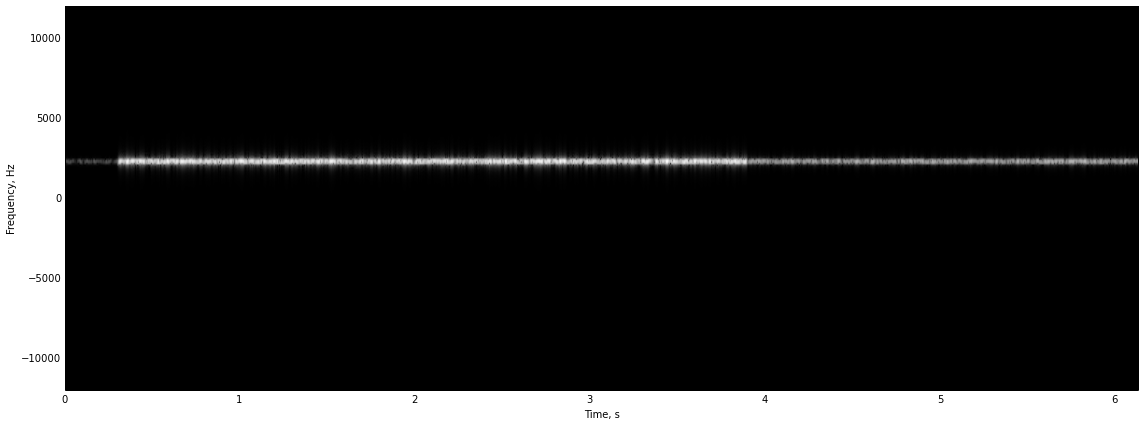

In [408]:
# your code here
freq = 2200
t = np.linspace(0,513/(fs_sdr/10),513)
modulator = np.exp(2j*pi*freq*t)
ssb_filter = np.hanning(513)*modulator

y_ssb_filt = signal.fftconvolve(demoded, ssb_filter, 'same')[30e3:-2000]

plot(np.abs(y_ssb_filt))
plt.title('Magnitude of SSB filtered data')
plt.xlabel('time [samples]')

myspectrogram_hann_ovlp(y_ssb_filt,m,fs_sdr/10,0);

### Transmitting your callsign in Morse code

The next step is to see if you can transmit something more meaningful. If you are going to transmit for the first time using a computer, you might as well transmit your callsign in Morse code!

Morse code is composed of dots ( . dit) and dashes ( - dah). The timing is relative to a dot duration which is one unit long. A dah is three units long. Gap between dots and dashes within a character is one unit. A short gap between letters is three units and a gap between words is seven units.

Here's a dictionary of Morse code:



* Implement a function `sig = text2Morse(text, fc, fs,dt)`. The function will take a string and convert it to a tone signal that plays the morse code of the text. The function will also take 'fc' the frequency of the tones (800-900Hz sounds nice), 'fs' the sampling frequency and 'dt' the morse unit time (hence the speed, 50-75ms recommended).
* Transmit your call sign! You can use this function to identify yourself before, during and after a transmission from now on.
* Validate the code by capturing a spectrogram using the SDR



In [393]:
def text2Morse(text,fc,fs,dt):
    CODE = {'A': '.-',     'B': '-...',   'C': '-.-.', 
        'D': '-..',    'E': '.',      'F': '..-.',
        'G': '--.',    'H': '....',   'I': '..',
        'J': '.---',   'K': '-.-',    'L': '.-..',
        'M': '--',     'N': '-.',     'O': '---',
        'P': '.--.',   'Q': '--.-',   'R': '.-.',
     	'S': '...',    'T': '-',      'U': '..-',
        'V': '...-',   'W': '.--',    'X': '-..-',
        'Y': '-.--',   'Z': '--..',
        
        '0': '-----',  '1': '.----',  '2': '..---',
        '3': '...--',  '4': '....-',  '5': '.....',
        '6': '-....',  '7': '--...',  '8': '---..',
        '9': '----.',

        ' ': ' ', "'": '.----.', '(': '-.--.-',  ')': '-.--.-',
        ',': '--..--', '-': '-....-', '.': '.-.-.-',
        '/': '-..-.',   ':': '---...', ';': '-.-.-.',
        '?': '..--..', '_': '..--.-'
        }
    
    Ndot= 1.0*fs*dt
    Ndah = 3*Ndot
    
    sdot = sin(2*pi*fc*r_[0.0:Ndot]/fs)
    sdah = sin(2*pi*fc*r_[0.0:Ndah]/fs)
    
    # convert to dit dah
    mrs = ""
    for char in text:
        mrs = mrs + CODE[char.upper()] + "*"
    
    sig = zeros(1)
    for char in mrs:
        if char == " ":
            sig = concatenate((sig,zeros(Ndot*7)))
        if char == "*":
            sig = concatenate((sig,zeros(Ndot*3)))
        if char == ".":
            sig = concatenate((sig,sdot,zeros(Ndot)))
        if char == "-":
            sig = concatenate((sig,sdah,zeros(Ndot)))
    return sig
            
    

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:43: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:41: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:39: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:37: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Closed  play thread


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:74: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


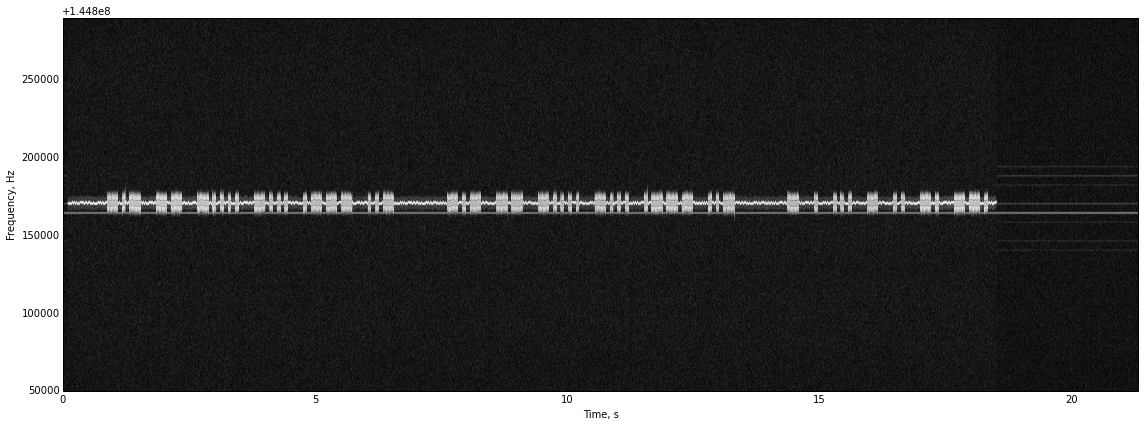

In [396]:
p = pyaudio.PyAudio()

fs = 240000
fc =  fc
sdr = RtlSdr()
sdr.sample_rate = fs    # sampling rate
sdr.gain = gain
sdr.center_freq = fc
sdr.set_freq_correction(ppm)


Q = Queue.Queue()
cQ = Queue.Queue()


# initialize a serial port (use COM1-9 for windows) 
s = serial.Serial(port='/dev/tty.SLAB_USBtoUART')
s.setDTR(0)

# get sampling rate
fs_usb = p.get_device_info_by_index(dusb_out)['defaultSampleRate']


callsign = text2Morse("KM6BJU KM6BJU TESTING",850,44100,75e-3)*0.1


Q.put(r_[0:44100.0*0.3]*0)
Q.put(callsign)
Q.put('KEYOFF')
Q.put('EOT')

t_play = threading.Thread(target = play_audio,   args = (Q, cQ,  p, 44100, dusb_out ,s ))

s.setDTR(1)
t_play.start()

y = sdr.read_samples(256000*20)
sdr.close()
s.setDTR(0)

while not(Q.empty()) :
    time.sleep(1)
    
p.terminate()
tt,ff,xmf = myspectrogram_hann_ovlp(y, 512, fs, fc,dbf = 60)
